# FLIR One Pro sensor calibration
## Part 2 - Analysing the effect of sensor rotation

As discovered in Part 1, the raw FIR and RGB images exported by the FLIR One do not line up perfectly.
I found a way to fit an affine transformation that aligns the two images.

However, the transformation that had been fit on landscape-pictures did not seem to work for portrait mode images.
This notebook explores the effect of camera rotation on the required linear transformation.

(Note that in the code `VIS`: visible, `THR`: thermal/FIR)

In [1]:
%matplotlib inline

import os
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pprint import pprint

# plt.rcParams['figure.figsize'] = [15, 11]

## Utilities

In [2]:
def load_images(path, name):
    """
        Loads original, thermal and visible image from dataset
    """
    original = cv2.imread(os.path.join(path, name)) / 255
    thermal = cv2.imread(os.path.join(path, "extracted/thermal", name)) / 255
    visible = cv2.imread(os.path.join(path, "extracted/visible", name)) / 255
    return original, thermal, visible

def load_prepare(path, name):
    """
        Loads images, scales VIS and FIR to shape and collapses to 1 channel
    """
    orig, thr, vis = load_images(path, name)
    
    # Compress into single channel
    thr = np.mean(thr, 2)
    vis = np.mean(vis, 2)

    # Align shapes
    vis = cv2.resize(vis, (thr.shape[1], thr.shape[0]))
    return orig, thr, vis

def superimpose(a, b):
    """
        Superimposes 2 images
    """
    return np.mean(np.dstack([a, b]), axis=2)

def show(img, ax, title, neg=True):
    """
        Displays an image.
        Uses negative by default for better visibility.
    """
    ax.imshow(1-img if neg else img)
    ax.set_title(title)
    ax.axis("off")

## Load metadata

This file contains experimental results, filenames and annotations.

In [3]:
root_path = "../../data/calibration_rotation"
with open(os.path.join(root_path, "metadata.json")) as f:
    metadata = json.load(f)
    
scaling_factor = metadata["shape"]["vis"][0] / metadata["shape"]["thr"][0]
pprint(metadata)

{'photos': {'flir_20191116T103250.jpg': {'angle': 0,
                                         'points': {'thr': [[115, 182],
                                                            [93, 557],
                                                            [416, 287]],
                                                    'vis': [[327, 474],
                                                            [296, 1175],
                                                            [884, 675]]}},
            'flir_20191116T103300.jpg': {'angle': 45,
                                         'points': {'thr': [[239, 123],
                                                            [71, 390],
                                                            [290, 526]],
                                                    'vis': [[547, 368],
                                                            [247, 866],
                                                            [655, 1116]]}},
            'flir_201

## Learn linear transformation

Use linear regression to estimate the parameters of an affine transformation.

In [4]:
from sklearn.linear_model import LinearRegression

/Users/lindronics/opt/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

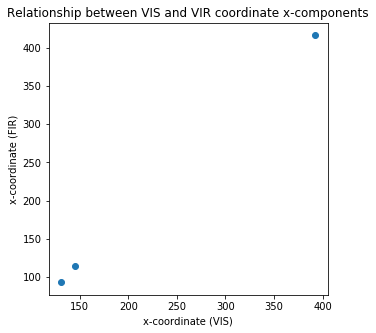

In [5]:
# Load reference points

X = metadata["photos"]["flir_20191116T103250.jpg"]["points"]["vis"]
y = metadata["photos"]["flir_20191116T103250.jpg"]["points"]["thr"]
    
X = np.vstack(X) // scaling_factor
y = np.vstack(y)

# Plot thermal x-value over visible x-value
# there appears to be a linear relationship
fig, ax = plt.subplots(1, figsize=(5,5))
ax.scatter(X[:, 0], y[:, 0])
ax.set_xlabel("x-coordinate (VIS)")
ax.set_ylabel("x-coordinate (FIR)")
ax.set_title("Relationship between VIS and VIR coordinate x-components")
fig.show()

model = LinearRegression()
model.fit(X, y)

## Visualise transformation using points and vectors

In [6]:
def show_transform(path, name, metadata, coef, intercept, scaling_factor):
    """
        Displays transformation vectors as an overlay
        over the superimposed FIR and RGB image
    """
    orig, thr, vis = load_prepare(path, name)
    
    # Display superimposed image
    sup = superimpose(vis, thr*3)
    
    fig, ax = plt.subplots(1)
    show(sup, ax, "Transformation of selected points", neg=False)

    # Test points
    X_test = np.array([[100, 100], [550, 100], [100, 400], [550, 400]])
    X_test = np.vstack([X_test, np.array(metadata["photos"][name]["points"]["vis"]) / scaling_factor])

    # Arrows
    y_pred = model.predict(X_test)
    for i in range(X_test.shape[0]):
        ax.annotate("", xy=X_test[i] @ coef.T + intercept, xytext=X_test[i], arrowprops=dict(arrowstyle="->", color="white", linewidth=3))

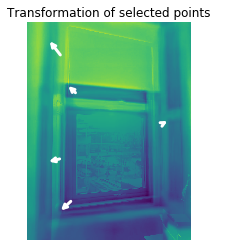

In [7]:
show_transform(root_path, "flir_20191116T103250.jpg", metadata, model.coef_, model.intercept_, scaling_factor)

## Align and superimpose using affine transformation

In [8]:
from scipy.ndimage import affine_transform

def align(path, name, coef, intercept, rotated=False):
    orig, thr, vis = load_prepare(path, name)
    
    sup_before = superimpose(vis, thr*3)
    
    # If portrait mode, rotate images so that the transformation works properly
    if rotated:
        thr = np.rot90(thr, 1)
        vis = np.rot90(vis, 1)
        
    transformation = np.hstack([coef, intercept[:, None]])
    vis = cv2.warpAffine(vis, transformation, (thr.shape[1], thr.shape[0]))

    sup_after = superimpose(vis, thr*3)
    
    if rotated:
        sup_after = np.rot90(sup_after, 3)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    show(sup_before, ax1, "Before transformation")
    show(orig, ax2, "Original", neg=True)
    show(sup_after, ax3, "After transformation")
    
    fig.suptitle(f"Aligning FIR and VIS by affine transformation", y=.82, size="xx-large")
    plt.tight_layout()

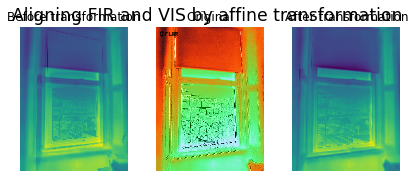

In [9]:
align(root_path, "flir_20191116T103250.jpg", model.coef_, model.intercept_)

## Validate on different image

Finally, test how the transformation works on different rotations.

### Try 45°

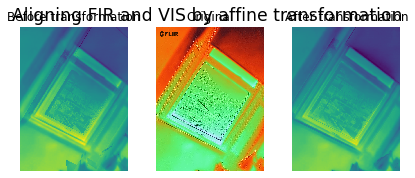

In [10]:
align(root_path, "flir_20191116T103300.jpg", model.coef_, model.intercept_)

So far the alignment seems okay.

### Try 90°, 135° and 180°

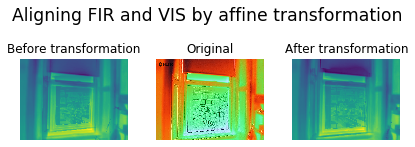

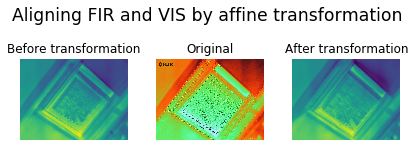

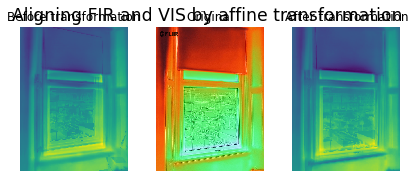

In [11]:
align(root_path, "flir_20191116T103306.jpg", model.coef_, model.intercept_, rotated=True)
align(root_path, "flir_20191116T103313.jpg", model.coef_, model.intercept_, rotated=True)
align(root_path, "flir_20191116T103321.jpg", model.coef_, model.intercept_, rotated=True)

These images don't seem to line up very well.

## Analysing the transformations

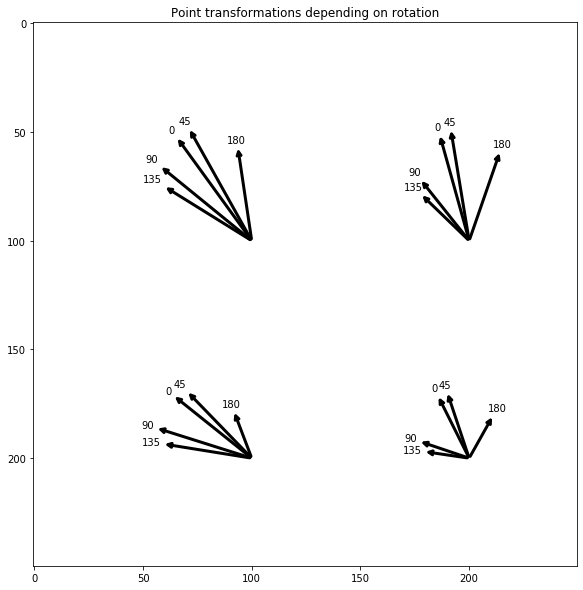

In [12]:
fig, ax = plt.subplots(1, figsize=(10, 10))
bg = np.ones(shape=(250, 250), dtype=float)
ax.imshow(bg, cmap="gray", vmin=0, vmax=1)

p1 = np.array([100, 100], dtype=float)
p2 = np.array([200, 100], dtype=float)
p3 = np.array([100, 200], dtype=float)
p4 = np.array([200, 200], dtype=float)

coef, intercept, angle = [], [], []
for name, image in metadata["photos"].items():
    X = metadata["photos"][name]["points"]["vis"]
    y = metadata["photos"][name]["points"]["thr"]

    X = np.vstack(X) // scaling_factor
    y = np.vstack(y)

    model = LinearRegression()
    model.fit(X, y)

    t1 = p1 @ model.coef_.T + model.intercept_
    t2 = p2 @ model.coef_.T + model.intercept_
    t3 = p3 @ model.coef_.T + model.intercept_
    t4 = p4 @ model.coef_.T + model.intercept_

    ax.annotate(metadata["photos"][name]["angle"], xy=p1, xytext=t1, arrowprops=dict(arrowstyle="<-", linewidth=3))
    ax.annotate(metadata["photos"][name]["angle"], xy=p2, xytext=t2, arrowprops=dict(arrowstyle="<-", linewidth=3))
    ax.annotate(metadata["photos"][name]["angle"], xy=p3, xytext=t3, arrowprops=dict(arrowstyle="<-", linewidth=3))
    ax.annotate(metadata["photos"][name]["angle"], xy=p4, xytext=t4, arrowprops=dict(arrowstyle="<-", linewidth=3))

ax.set_title("Point transformations depending on rotation")

pass

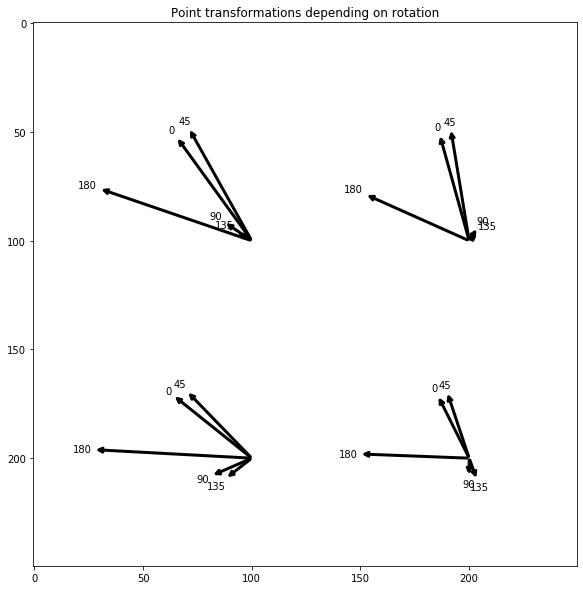

In [13]:
fig, ax = plt.subplots(1, figsize=(10, 10))
bg = np.ones(shape=(250, 250), dtype=float)
ax.imshow(bg, cmap="gray", vmin=0, vmax=1)

p1 = np.array([100, 100], dtype=float)
p2 = np.array([200, 100], dtype=float)
p3 = np.array([100, 200], dtype=float)
p4 = np.array([200, 200], dtype=float)

vis_shape = np.array(metadata["shape"]["vis"])
thr_shape = np.array(metadata["shape"]["thr"])

coef, intercept, angle = [], [], []
for name, image in metadata["photos"].items():
    angle = metadata["photos"][name]["angle"]
    
    X = metadata["photos"][name]["points"]["vis"]
    y = metadata["photos"][name]["points"]["thr"]

    X = np.vstack(X) // scaling_factor
    y = np.vstack(y)
    
    if angle >= 180:
        X = vis_shape // scaling_factor - X
        y = thr_shape - y
    elif angle >= 90:
        X = X[:, ::-1]
        X[:, 1] = vis_shape[1] // scaling_factor - X[:, 1]
        y = y[:, ::-1]
        y[:, 1] = thr_shape[1] - y[:, 1]
        
        
    model = LinearRegression()
    model.fit(X, y)

    t1 = p1 @ model.coef_.T + model.intercept_
    t2 = p2 @ model.coef_.T + model.intercept_
    t3 = p3 @ model.coef_.T + model.intercept_
    t4 = p4 @ model.coef_.T + model.intercept_

    ax.annotate(metadata["photos"][name]["angle"], xy=p1, xytext=t1, arrowprops=dict(arrowstyle="<-", linewidth=3))
    ax.annotate(metadata["photos"][name]["angle"], xy=p2, xytext=t2, arrowprops=dict(arrowstyle="<-", linewidth=3))
    ax.annotate(metadata["photos"][name]["angle"], xy=p3, xytext=t3, arrowprops=dict(arrowstyle="<-", linewidth=3))
    ax.annotate(metadata["photos"][name]["angle"], xy=p4, xytext=t4, arrowprops=dict(arrowstyle="<-", linewidth=3))

ax.set_title("Point transformations depending on rotation")

pass